In [370]:
!git clone https://github.com/DanteMillerDS/NASA-Material-Classifier.git

Cloning into 'NASA-Material-Classifier'...
remote: Enumerating objects: 97, done.
remote: Total 97 (delta 0), reused 0 (delta 0), pack-reused 97
Receiving objects: 100% (97/97), 44.48 MiB | 12.36 MiB/s, done.
Resolving deltas: 100% (28/28), done.


In [371]:
%cd NASA-Material-Classifier

/content/NASA-Material-Classifier/NASA-Material-Classifier/NASA-Material-Classifier/NASA-Material-Classifier/NASA-Material-Classifier


In [372]:
import numpy as np
np.random.seed(500)
import pandas as pd
import tensorflow as tf
tf.random.set_seed(500)
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import torch.optim.lr_scheduler as lr_scheduler
import scipy.io
import torch.nn as nn
from sklearn.model_selection import train_test_split
import uuid
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader

In [373]:
file_paths = dict()
file_paths[0] = [
    "data/S11_parameter_data_for_zero_orientation.txt",
    "data/S12_parameter_data_for_zero_orientation.txt",
    "data/S21_parameter_data_for_zero_orientation.txt",
    "data/S22_parameter_data_for_zero_orientation.txt"]
file_paths[1] = [
    "data/S11_parameter_data_for_CW90_orientation.txt",
    "data/S12_parameter_data_for_CW90_orientation.txt",
    "data/S21_parameter_data_for_CW90_orientation.txt",
    "data/S22_parameter_data_for_CW90_orientation.txt"]
file_paths[2] = [
    "data/S11_parameter_data_for_CCW90_orientation.txt",
    "data/S12_parameter_data_for_CCW90_orientation.txt",
    "data/S21_parameter_data_for_CCW90_orientation.txt",
    "data/S22_parameter_data_for_CCW90_orientation.txt"]
file_paths[3] = [
    "data/S11_parameter_data_for_tilt_orientation.txt",
    "data/S12_parameter_data_for_tilt_orientation.txt",
    "data/S21_parameter_data_for_tilt_orientation.txt",
    "data/S22_parameter_data_for_tilt_orientation.txt"]
def process_file(file_path,orientation):
    datasets = []
    with open(file_path, 'r') as file:
        current_dataset = []
        for line in file:
            if line.startswith("#Parameters"):
                if current_dataset:
                    datasets.append(current_dataset)
                    current_dataset = []
                params_str = line[line.index("{") + 1:line.index("}")]
                params = dict(param.split('=') for param in params_str.split(';'))
                current_dataset.append(params)
            elif line.startswith("#"):
                continue
            else:
                data = line.strip().split('\t')
                current_dataset.append(data)
        if current_dataset:
            datasets.append(current_dataset)
    data = []
    for dataset in datasets:
        permittivity_values = dataset[0]
        df_data = dataset[1:]
        s_parameter_name = file_path.split("_parameter_data_for_")[0]
        df = pd.DataFrame(df_data, columns=["Frequency", f"{s_parameter_name}_Real", f"{s_parameter_name}_Imaginary"])
        df["Orientation"] = orientation
        df["ID"] = str(uuid.uuid4())[:8]
        for key, value in permittivity_values.items():
            if "er1" in key or "er11" in key:
                df[key] = value
        data.append(df)
    return data
all_combined_data = []
for index in file_paths:
    for file in file_paths[index]:
        combined_data = process_file(file,index)
        combined_data = pd.concat(combined_data, ignore_index=True)
        all_combined_data.append(combined_data)
array = []
group_size = 4
for i in range(0, len(all_combined_data), group_size):
    combined_dataframe = pd.concat(all_combined_data[i:i+group_size], axis=1)
    combined_dataframe.reset_index(drop=True, inplace=True)
    #combined_dataframe = combined_dataframe.T.drop_duplicates().T
    array.append(combined_dataframe)
training_dataframe = pd.concat(array, axis=0)
training_dataframe.reset_index(drop=True, inplace=True)
training_dataframe = training_dataframe.loc[:, ~training_dataframe.columns.duplicated()]

In [374]:
file_paths = dict()
file_paths[0] = ["data/mea_rot_0.txt"]
file_paths[1] = ["data/mea_rot_cw90.txt"]
file_paths[2] = ["data/mea_rot_ccw90.txt"]
file_paths[3] = ["data/mea_rot_0_tilt.txt"]
# Function to process each file and merge datasets
def process_file(file_path,orientation):
    datasets = []
    with open(file_path, 'r') as file:
        current_dataset = []
        for line in file:
            if line.startswith("#Parameters"):
                if current_dataset:
                    datasets.append(current_dataset)
                    current_dataset = []
                params_str = line[line.index("{") + 1:line.index("}")]
                params = dict(param.split('=') for param in params_str.split(';'))
                current_dataset.append(params)
            elif line.startswith("#"):
                continue
            else:
                data = line.strip().split('\t')
                current_dataset.append(data)
        if current_dataset:
            datasets.append(current_dataset)
    dictionary = {
    0: "S11",
    1: "S21",
    2: "S12",
    3: "S22"
    }
    data = []
    for index, dataset in enumerate(datasets):
        permittivity_values = dataset[0]
        df_data = dataset[1:]
        s_parameter_name = dictionary[index]
        df = pd.DataFrame(df_data, columns=["Frequency", f"{s_parameter_name}_Real", f"{s_parameter_name}_Imaginary"])
        df["Orientation"] = orientation
        df["ID"] = str(uuid.uuid4())[:8]
        for key, value in permittivity_values.items():
            if "er1" in key or "er11" in key:
                df[key] = value
        data.append(df)
    return data
all_combined_data = []
for index in file_paths:
    for file in file_paths[index]:
        combined_data = process_file(file,index)
        all_combined_data.append(combined_data)
array = []
group_size = 4
for group in range(len(all_combined_data)):
    for i in range(0, len(all_combined_data[group]), group_size):
        combined_dataframe = pd.concat(all_combined_data[group][i:i+group_size], axis=1)
        combined_dataframe.reset_index(drop=True, inplace=True)
        array.append(combined_dataframe)
testing_dataframe = pd.concat(array, axis=0)
testing_dataframe.reset_index(drop=True, inplace=True)
testing_dataframe = testing_dataframe.loc[:, ~testing_dataframe.columns.duplicated()]

In [375]:
training_dataframe.columns = ['Frequency', 'S11_Real', 'S11_Imaginary', 'Orientation', 'ID','Permittivity_Real', 'Permittivity_Imaginary', 'S21_Real',
       'S21_Imaginary', 'S12_Real', 'S12_Imaginary', 'S22_Real',
       'S22_Imaginary']
training_dataframe = training_dataframe[['ID','Frequency', 'Orientation', 'Permittivity_Real', 'Permittivity_Imaginary','S11_Real', 'S11_Imaginary', 'S12_Real',
       'S12_Imaginary', 'S21_Real', 'S21_Imaginary', 'S22_Real',
       'S22_Imaginary']]
testing_dataframe.columns = ['Frequency', 'S11_Real', 'S11_Imaginary', 'Orientation', 'ID','Permittivity_Real', 'Permittivity_Imaginary', 'S21_Real',
       'S21_Imaginary', 'S12_Real', 'S12_Imaginary', 'S22_Real',
       'S22_Imaginary']
testing_dataframe = testing_dataframe[['ID','Frequency', 'Orientation',  'Permittivity_Real', 'Permittivity_Imaginary','S11_Real', 'S11_Imaginary', 'S12_Real',
       'S12_Imaginary', 'S21_Real', 'S21_Imaginary', 'S22_Real',
       'S22_Imaginary']]

In [376]:
training_dataframe.head(5)

,ID,Frequency,Orientation,Permittivity_Real,Permittivity_Imaginary,S11_Real,S11_Imaginary,S12_Real,S12_Imaginary,S21_Real,S21_Imaginary,S22_Real,S22_Imaginary
0,5eed8c8b,1.0000000000000,0,2.2609046534204,0.04505415985025,0.010708443820477,-0.0015462124720216,0.21881757676601,0.96427404880524,0.21881759166718,0.96427410840988,0.010326976887882,-0.0032272436656058
1,5eed8c8b,1.0006999969482,0,2.2609046534204,0.04505415985025,0.010755277238786,-0.0017734571592882,0.23742462694645,0.96046137809753,0.23742462694645,0.96046137809753,0.010342826135457,-0.0034419626463205
2,5eed8c8b,1.0013999938965,0,2.2609046534204,0.04505415985025,0.010795198380947,-0.0020041132811457,0.25594717264175,0.95629817247391,0.25594717264175,0.95629823207855,0.010353058576584,-0.0036560846492648
3,5eed8c8b,1.0020999908447,0,2.2609046534204,0.04505415985025,0.010827971622348,-0.0022378272842616,0.27437821030617,0.95178377628326,0.27437824010849,0.95178383588791,0.010357595048845,-0.0038695030380040
4,5eed8c8b,1.0027999877930,0,2.2609046534204,0.04505415985025,0.010853389278054,-0.0024742297828197,0.29271024465561,0.94691836833954,0.29271024465561,0.94691836833954,0.010356365703046,-0.0040821037255228


In [377]:
testing_dataframe.head(5)

,ID,Frequency,Orientation,Permittivity_Real,Permittivity_Imaginary,S11_Real,S11_Imaginary,S12_Real,S12_Imaginary,S21_Real,S21_Imaginary,S22_Real,S22_Imaginary
0,16dc597b,1.0000000000000,0,5,0.1,-0.019713426000000,-0.0060391319000000,0.99922335000000,-0.020864042000000,0.99841827000000,-0.021599129000000,0.021094969000000,-0.0067798547000000
1,16dc597b,1.0007000000000,0,5,0.1,-0.019482541585540,-0.0063846667326036,0.99871819006375,-0.020888964080002,0.99862961142762,-0.021390875332731,0.020910906076745,-0.0072704463377855
2,16dc597b,1.0014000000000,0,5,0.1,-0.019137625649780,-0.0065910681665272,0.99827064270063,-0.020941499353097,0.99844536227299,-0.021037567314369,0.020691122020212,-0.0077301113670862
3,16dc597b,1.0021000000000,0,5,0.1,-0.018813112374285,-0.0069965346072957,0.99820293745227,-0.020767770604437,0.99824771176501,-0.020766027366779,0.020422204537027,-0.0081046434147131
4,16dc597b,1.0028000000000,0,5,0.1,-0.018616413134193,-0.0076122439176546,0.99851990287783,-0.020519403197245,0.99826510603014,-0.020614971186886,0.020163732147648,-0.0083827107262601


In [378]:
training_dataframe.dropna(inplace=True)
columns = training_dataframe.columns[1:]
training_dataframe[columns] = training_dataframe[columns].apply(pd.to_numeric)
testing_dataframe.dropna(inplace=True)
testing_dataframe[columns] = testing_dataframe[columns].apply(pd.to_numeric)

In [379]:
training_dataframe.head(5)

,ID,Frequency,Orientation,Permittivity_Real,Permittivity_Imaginary,S11_Real,S11_Imaginary,S12_Real,S12_Imaginary,S21_Real,S21_Imaginary,S22_Real,S22_Imaginary
0,5eed8c8b,1.0000,0,2.260905,0.045054,0.010708,-0.001546,0.218818,0.964274,0.218818,0.964274,0.010327,-0.003227
1,5eed8c8b,1.0007,0,2.260905,0.045054,0.010755,-0.001773,0.237425,0.960461,0.237425,0.960461,0.010343,-0.003442
2,5eed8c8b,1.0014,0,2.260905,0.045054,0.010795,-0.002004,0.255947,0.956298,0.255947,0.956298,0.010353,-0.003656
3,5eed8c8b,1.0021,0,2.260905,0.045054,0.010828,-0.002238,0.274378,0.951784,0.274378,0.951784,0.010358,-0.003870
4,5eed8c8b,1.0028,0,2.260905,0.045054,0.010853,-0.002474,0.292710,0.946918,0.292710,0.946918,0.010356,-0.004082


In [380]:
testing_dataframe.head(5)

,ID,Frequency,Orientation,Permittivity_Real,Permittivity_Imaginary,S11_Real,S11_Imaginary,S12_Real,S12_Imaginary,S21_Real,S21_Imaginary,S22_Real,S22_Imaginary
0,16dc597b,1.0000,0,5,0.1,-0.019713,-0.006039,0.999223,-0.020864,0.998418,-0.021599,0.021095,-0.006780
1,16dc597b,1.0007,0,5,0.1,-0.019483,-0.006385,0.998718,-0.020889,0.998630,-0.021391,0.020911,-0.007270
2,16dc597b,1.0014,0,5,0.1,-0.019138,-0.006591,0.998271,-0.020941,0.998445,-0.021038,0.020691,-0.007730
3,16dc597b,1.0021,0,5,0.1,-0.018813,-0.006997,0.998203,-0.020768,0.998248,-0.020766,0.020422,-0.008105
4,16dc597b,1.0028,0,5,0.1,-0.018616,-0.007612,0.998520,-0.020519,0.998265,-0.020615,0.020164,-0.008383


In [381]:
training_dataframe["Permittivity_Real"] /= 100
testing_dataframe["Permittivity_Real"] /= 100

In [382]:
columns = []
for column in training_dataframe.columns:
    if column != "Permittivity_Real" and column !="Permittivity_Imaginary":
        columns.append(column)
columns

['ID',
 'Frequency',
 'Orientation',
 'S11_Real',
 'S11_Imaginary',
 'S12_Real',
 'S12_Imaginary',
 'S21_Real',
 'S21_Imaginary',
 'S22_Real',
 'S22_Imaginary']

In [383]:
testing_dataframe['Permittivity_Imaginary'][testing_dataframe['Permittivity_Imaginary'] == 0.4] = 0.1

In [384]:
training_dataframe.head(5)

,ID,Frequency,Orientation,Permittivity_Real,Permittivity_Imaginary,S11_Real,S11_Imaginary,S12_Real,S12_Imaginary,S21_Real,S21_Imaginary,S22_Real,S22_Imaginary
0,5eed8c8b,1.0000,0,0.022609,0.045054,0.010708,-0.001546,0.218818,0.964274,0.218818,0.964274,0.010327,-0.003227
1,5eed8c8b,1.0007,0,0.022609,0.045054,0.010755,-0.001773,0.237425,0.960461,0.237425,0.960461,0.010343,-0.003442
2,5eed8c8b,1.0014,0,0.022609,0.045054,0.010795,-0.002004,0.255947,0.956298,0.255947,0.956298,0.010353,-0.003656
3,5eed8c8b,1.0021,0,0.022609,0.045054,0.010828,-0.002238,0.274378,0.951784,0.274378,0.951784,0.010358,-0.003870
4,5eed8c8b,1.0028,0,0.022609,0.045054,0.010853,-0.002474,0.292710,0.946918,0.292710,0.946918,0.010356,-0.004082


In [385]:
testing_dataframe.head(5)

,ID,Frequency,Orientation,Permittivity_Real,Permittivity_Imaginary,S11_Real,S11_Imaginary,S12_Real,S12_Imaginary,S21_Real,S21_Imaginary,S22_Real,S22_Imaginary
0,16dc597b,1.0000,0,0.05,0.1,-0.019713,-0.006039,0.999223,-0.020864,0.998418,-0.021599,0.021095,-0.006780
1,16dc597b,1.0007,0,0.05,0.1,-0.019483,-0.006385,0.998718,-0.020889,0.998630,-0.021391,0.020911,-0.007270
2,16dc597b,1.0014,0,0.05,0.1,-0.019138,-0.006591,0.998271,-0.020941,0.998445,-0.021038,0.020691,-0.007730
3,16dc597b,1.0021,0,0.05,0.1,-0.018813,-0.006997,0.998203,-0.020768,0.998248,-0.020766,0.020422,-0.008105
4,16dc597b,1.0028,0,0.05,0.1,-0.018616,-0.007612,0.998520,-0.020519,0.998265,-0.020615,0.020164,-0.008383


In [386]:
columns = training_dataframe.columns[3:]
training_mean_predicted_values = training_dataframe.groupby('Frequency')[columns].mean()
testing_mean_predicted_values = testing_dataframe.groupby('Frequency')[columns].mean()

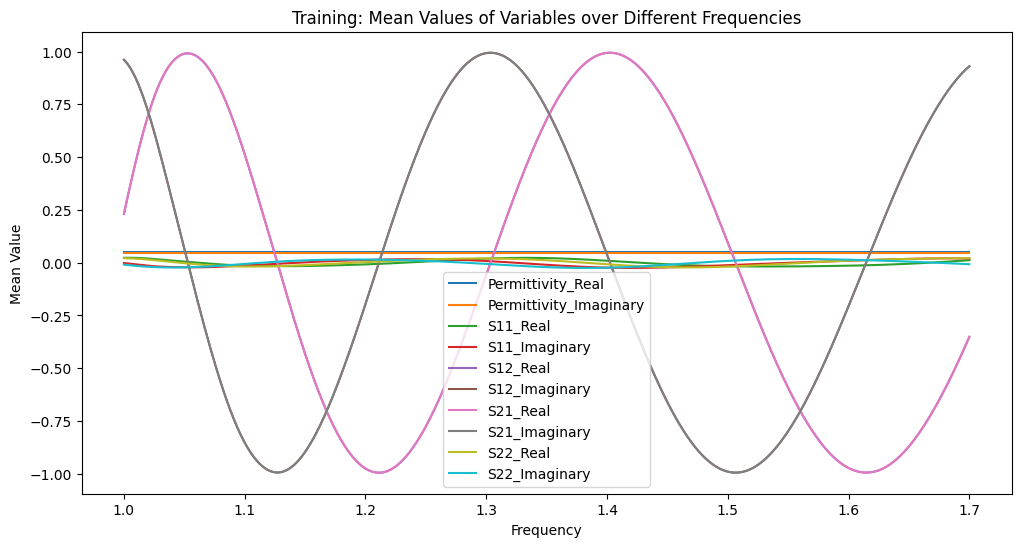

In [387]:
plt.figure(figsize=(12, 6))
for col in training_mean_predicted_values.columns:
    plt.plot(training_mean_predicted_values.index, training_mean_predicted_values[col], label=col)
plt.xlabel('Frequency')
plt.ylabel('Mean Value')
plt.title('Training: Mean Values of Variables over Different Frequencies')
plt.legend()
plt.show()

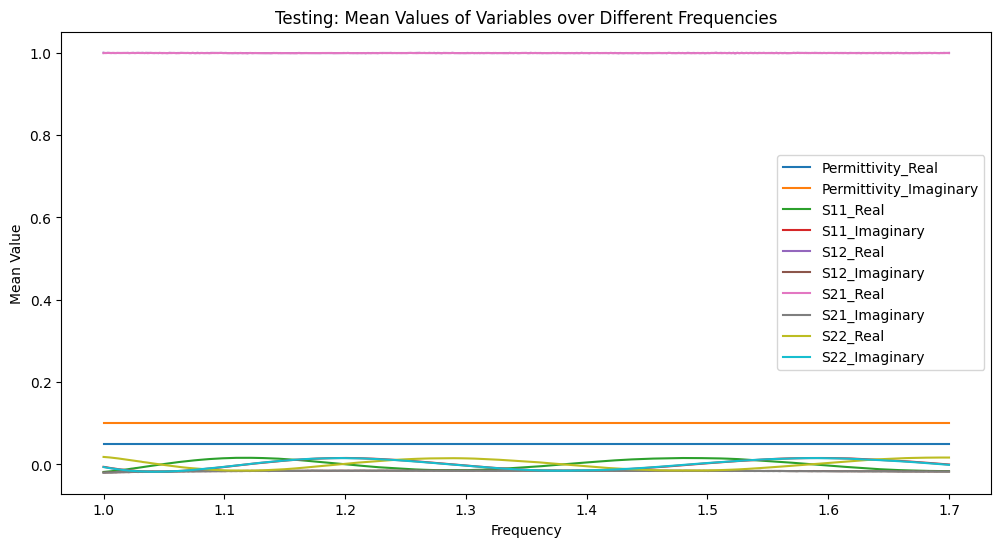

In [388]:
plt.figure(figsize=(12, 6))
for col in testing_mean_predicted_values.columns:
    plt.plot(testing_mean_predicted_values.index, testing_mean_predicted_values[col], label=col)
plt.xlabel('Frequency')
plt.ylabel('Mean Value')
plt.title('Testing: Mean Values of Variables over Different Frequencies')
plt.legend()
plt.show()

In [389]:
class TimeSeriesDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe.groupby('ID')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data.get_group(list(self.data.groups.keys())[idx])
        frequency = torch.tensor(sample['Frequency'].values, dtype=torch.float32)
        orientation = torch.tensor(sample['Orientation'].values, dtype=torch.float32)
        permittivity_real = torch.tensor(sample['Permittivity_Real'].values, dtype=torch.float32)
        permittivity_imaginary = torch.tensor(sample['Permittivity_Imaginary'].values, dtype=torch.float32)
        s11_real = torch.tensor(sample['S11_Real'].values, dtype=torch.float32)
        s11_imaginary = torch.tensor(sample['S11_Imaginary'].values, dtype=torch.float32)
        s12_real = torch.tensor(sample['S12_Real'].values, dtype=torch.float32)
        s12_imaginary = torch.tensor(sample['S12_Imaginary'].values, dtype=torch.float32)
        s21_real = torch.tensor(sample['S21_Real'].values, dtype=torch.float32)
        s21_imaginary = torch.tensor(sample['S21_Imaginary'].values, dtype=torch.float32)
        s22_real = torch.tensor(sample['S22_Real'].values, dtype=torch.float32)
        s22_imaginary = torch.tensor(sample['S22_Imaginary'].values, dtype=torch.float32)

        return (permittivity_real, permittivity_imaginary,frequency, orientation,
                s11_real, s11_imaginary, s12_real, s12_imaginary,
                s21_real, s21_imaginary, s22_real, s22_imaginary)


In [390]:
batch_size = 1
train_ids, val_ids = train_test_split(training_dataframe['ID'].unique(), test_size=0.20, random_state=100)
train_dataset = training_dataframe[training_dataframe['ID'].isin(train_ids)]
val_dataset = training_dataframe[training_dataframe['ID'].isin(val_ids)]
train_dataloader = DataLoader(TimeSeriesDataset(train_dataset), batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(TimeSeriesDataset(val_dataset), batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(TimeSeriesDataset(testing_dataframe), batch_size=batch_size, shuffle=False)

In [391]:
class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BiLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, 256)  # Multiply hidden_size by 2 for bidirectional LSTM
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, 64)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(64, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)  # Multiply num_layers by 2 for bidirectional LSTM
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        context_vector = out.mean(dim=1)
        out = self.fc(context_vector)  # Use the context vector for prediction
        out = self.fc2(self.relu1(out))
        out = self.fc3(self.relu2(out))
        out = self.fc4(self.relu3(out))
        return out


In [392]:
input_size = 10
hidden_size = 128
num_layers = 1
output_size = 2
model = BiLSTMModel(input_size, hidden_size, num_layers, output_size)

In [393]:
criterion = nn.L1Loss()
mse_loss = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)

In [394]:
model

BiLSTMModel(
  (lstm): LSTM(10, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=256, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=64, out_features=2, bias=True)
)

In [395]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
num_epochs = 50
train_loss = []
val_loss = []
train_accuracy = dict()
train_accuracy["mse"] = []
validation_accuracy = dict()
validation_accuracy["mse"] = []
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    train_accuracy["mse"] = {}
    train_accuracy["mse"][epoch] = 0
    for inputs in train_dataloader:
        inputs = [inp.to(device) for inp in inputs]
        permittivity_real, permittivity_imaginary, frequency, orientation, \
        s11_real, s11_imaginary, s12_real, s12_imaginary, \
        s21_real, s21_imaginary, s22_real, s22_imaginary = inputs
        input_features = torch.cat([frequency.unsqueeze(2),
                                   orientation.unsqueeze(2),
                                   s11_real.unsqueeze(2),
                                   s11_imaginary.unsqueeze(2),
                                   s12_real.unsqueeze(2),
                                   s12_imaginary.unsqueeze(2),
                                   s21_real.unsqueeze(2),
                                   s21_imaginary.unsqueeze(2),
                                   s22_real.unsqueeze(2),
                                   s22_imaginary.unsqueeze(2)], dim=2)
        outputs = model(input_features)
        output_real_first = outputs[0, 0]
        output_imaginary_first = outputs[0, 1]
        permittivity_real_first = permittivity_real[0][0]
        permittivity_imaginary_first = permittivity_imaginary[0][0]
        loss_real = criterion(output_real_first, permittivity_real_first)
        loss_imaginary = mse_loss(output_imaginary_first, permittivity_imaginary_first)
        combined_loss = 0.5 * loss_real + 0.5 * loss_imaginary
        optimizer.zero_grad()
        combined_loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(),5)
        optimizer.step()

        total_train_loss += combined_loss.item()

        loss_real = mse_loss(output_real_first, permittivity_real_first)
        loss_imaginary = mse_loss(output_imaginary_first, permittivity_imaginary_first)
        combined_loss = 0.5 * loss_real + 0.5 * loss_imaginary
        train_accuracy["mse"][epoch] = train_accuracy["mse"][epoch] + combined_loss
    train_loss.append(total_train_loss)
    model.eval()
    with torch.no_grad():
      total_val_loss = 0
      validation_accuracy["mse"] = dict()
      validation_accuracy["mse"][epoch] = 0
      for inputs in val_dataloader:
            inputs = [inp.to(device) for inp in inputs]
            permittivity_real, permittivity_imaginary, frequency, orientation, \
            s11_real, s11_imaginary, s12_real, s12_imaginary, \
            s21_real, s21_imaginary, s22_real, s22_imaginary = inputs

            input_features = torch.cat([frequency.unsqueeze(2),
                                   orientation.unsqueeze(2),
                                   s11_real.unsqueeze(2),
                                   s11_imaginary.unsqueeze(2),
                                   s12_real.unsqueeze(2),
                                   s12_imaginary.unsqueeze(2),
                                   s21_real.unsqueeze(2),
                                   s21_imaginary.unsqueeze(2),
                                   s22_real.unsqueeze(2),
                                   s22_imaginary.unsqueeze(2)], dim=2)

            outputs = model(input_features)
            output_real_first = outputs[0, 0]
            output_imaginary_first = outputs[0, 1]


            permittivity_real_first = permittivity_real[0][0]
            permittivity_imaginary_first = permittivity_imaginary[0][0]

            loss_real = criterion(output_real_first, permittivity_real_first)
            loss_imaginary = mse_loss(output_imaginary_first, permittivity_imaginary_first)
            combined_loss = 0.5 * loss_real + 0.5 * loss_imaginary
            total_val_loss += combined_loss.item()

            loss_real = mse_loss(output_real_first, permittivity_real_first)
            loss_imaginary = mse_loss(output_imaginary_first, permittivity_imaginary_first)
            combined_loss = 0.5 * loss_real + 0.5 * loss_imaginary
            validation_accuracy["mse"][epoch] = validation_accuracy["mse"][epoch] + combined_loss


    val_loss.append(total_val_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {total_train_loss / len(train_dataloader)}, Val Loss: {total_val_loss / len(val_dataloader)}')

print('Training finished.')

Epoch [1/50], Train Loss: 0.015327645123761613, Val Loss: 0.015637812454951928
Epoch [2/50], Train Loss: 0.013662209303765849, Val Loss: 0.014140692543878685
Epoch [3/50], Train Loss: 0.013093760998344806, Val Loss: 0.013548482897749636
Epoch [4/50], Train Loss: 0.012763143637766917, Val Loss: 0.013048879976850003
Epoch [5/50], Train Loss: 0.012513124372253515, Val Loss: 0.01269434659043327
Epoch [6/50], Train Loss: 0.01233355716922233, Val Loss: 0.012508765595703153
Epoch [7/50], Train Loss: 0.012180619530045077, Val Loss: 0.012319455703982385
Epoch [8/50], Train Loss: 0.012037868494735449, Val Loss: 0.012140983893186786
Epoch [9/50], Train Loss: 0.011911213782150298, Val Loss: 0.01203504523509764
Epoch [10/50], Train Loss: 0.011791017159703187, Val Loss: 0.011922788553783903
Epoch [11/50], Train Loss: 0.011681780423896271, Val Loss: 0.011819134824327194
Epoch [12/50], Train Loss: 0.011580339857027866, Val Loss: 0.01175476160569815
Epoch [13/50], Train Loss: 0.011485627851470781, Val 

KeyboardInterrupt: ignored

In [ ]:
average_train_loss_per_sample = [loss_item / len(train_dataloader) for loss_item in train_loss]
average_val_loss_per_sample = [loss_item / len(val_dataloader) for loss_item in val_loss]
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(len(average_train_loss_per_sample)), average_train_loss_per_sample)
plt.plot(range(len(average_val_loss_per_sample)), average_val_loss_per_sample)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.tight_layout()
plt.show()

In [397]:
predicted_values = []
actual_values = []
model.eval()
with torch.no_grad():
    for inputs in test_dataloader:
        inputs = [inp.to(device) for inp in inputs]
        permittivity_real, permittivity_imaginary, frequency, orientation, \
        s11_real, s11_imaginary, s12_real, s12_imaginary, \
        s21_real, s21_imaginary, s22_real, s22_imaginary = inputs
        input_features = torch.cat([frequency.unsqueeze(2),
                                    orientation.unsqueeze(2),
                                    s11_real.unsqueeze(2),
                                    s11_imaginary.unsqueeze(2),
                                    s12_real.unsqueeze(2),
                                    s12_imaginary.unsqueeze(2),
                                    s21_real.unsqueeze(2),
                                    s21_imaginary.unsqueeze(2),
                                    s22_real.unsqueeze(2),
                                    s22_imaginary.unsqueeze(2)], dim=2)
        outputs = model(input_features)
        output_real_first = outputs[0, 0]
        output_imaginary_first = outputs[0, 1]

        predicted_values.append((output_real_first.item(), output_imaginary_first.item()))
        actual_values.append((permittivity_real[0][0].item(), permittivity_imaginary[0][0].item()))
predicted_values = np.array(predicted_values)
actual_values = np.array(actual_values)

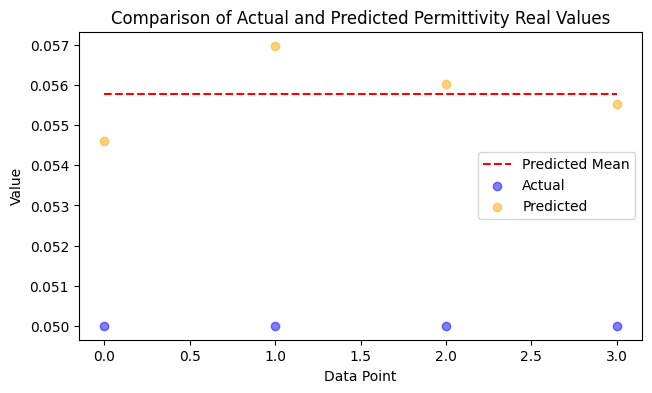

In [398]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot([0, len(actual_values) - 1], [np.mean(predicted_values[:, 0]), np.mean(predicted_values[:, 0])], label='Predicted Mean', color='red', linestyle='dashed')
plt.scatter(range(len(actual_values)), actual_values[:, 0], label='Actual', color='blue', alpha=0.5)
plt.scatter(range(len(actual_values)), predicted_values[:, 0], label='Predicted', color='orange', alpha=0.5)
plt.title('Comparison of Actual and Predicted Permittivity Real Values')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.legend()

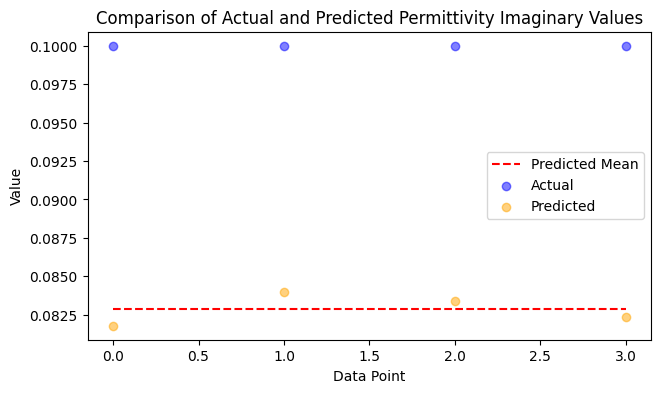

In [399]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot([0, len(actual_values) - 1], [np.mean(predicted_values[:, 1]), np.mean(predicted_values[:, 1])], label='Predicted Mean', color='red', linestyle='dashed')
plt.scatter(range(len(actual_values)), actual_values[:, 1], label='Actual', color='blue', alpha=0.5)
plt.scatter(range(len(actual_values)), predicted_values[:, 1], label='Predicted', color='orange', alpha=0.5)
plt.title('Comparison of Actual and Predicted Permittivity Imaginary Values')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.legend()

In [400]:
train_dataloader = DataLoader(TimeSeriesDataset(train_dataset), batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(TimeSeriesDataset(testing_dataframe), batch_size=batch_size, shuffle=False)

In [429]:
input_size = 10
hidden_size = 128
num_layers = 1
output_size = 2
model = BiLSTMModel(input_size, hidden_size, num_layers, output_size)

In [430]:
import torch.optim.lr_scheduler as lr_scheduler
criterion = nn.L1Loss()
mse_loss = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)

In [431]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
num_epochs = 10
train_loss = []
val_loss = []
train_accuracy = dict()
train_accuracy["mse"] = []
validation_accuracy = dict()
validation_accuracy["mse"] = []
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    train_accuracy["mse"] = {}
    train_accuracy["mse"][epoch] = 0
    for inputs in train_dataloader:
        inputs = [inp.to(device) for inp in inputs]
        permittivity_real, permittivity_imaginary, frequency, orientation, \
        s11_real, s11_imaginary, s12_real, s12_imaginary, \
        s21_real, s21_imaginary, s22_real, s22_imaginary = inputs
        input_features = torch.cat([frequency.unsqueeze(2),
                                   orientation.unsqueeze(2),
                                   s11_real.unsqueeze(2),
                                   s11_imaginary.unsqueeze(2),
                                   s12_real.unsqueeze(2),
                                   s12_imaginary.unsqueeze(2),
                                   s21_real.unsqueeze(2),
                                   s21_imaginary.unsqueeze(2),
                                   s22_real.unsqueeze(2),
                                   s22_imaginary.unsqueeze(2)], dim=2)
        outputs = model(input_features)
        output_real_first = outputs[0, 0]
        output_imaginary_first = outputs[0, 1]
        permittivity_real_first = permittivity_real[0][0]
        permittivity_imaginary_first = permittivity_imaginary[0][0]
        loss_real = criterion(output_real_first, permittivity_real_first)
        loss_imaginary = mse_loss(output_imaginary_first, permittivity_imaginary_first)
        combined_loss = 0.5 * loss_real + 0.5 * loss_imaginary
        optimizer.zero_grad()
        combined_loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(),5)
        optimizer.step()

        total_train_loss += combined_loss.item()

        loss_real = mse_loss(output_real_first, permittivity_real_first)
        loss_imaginary = mse_loss(output_imaginary_first, permittivity_imaginary_first)
        combined_loss = 0.5 * loss_real + 0.5 * loss_imaginary
        train_accuracy["mse"][epoch] = train_accuracy["mse"][epoch] + combined_loss
    train_loss.append(total_train_loss)
    model.eval()
    with torch.no_grad():
      total_val_loss = 0
      validation_accuracy["mse"] = dict()
      validation_accuracy["mse"][epoch] = 0
      for inputs in val_dataloader:
            inputs = [inp.to(device) for inp in inputs]
            permittivity_real, permittivity_imaginary, frequency, orientation, \
            s11_real, s11_imaginary, s12_real, s12_imaginary, \
            s21_real, s21_imaginary, s22_real, s22_imaginary = inputs

            input_features = torch.cat([frequency.unsqueeze(2),
                                   orientation.unsqueeze(2),
                                   s11_real.unsqueeze(2),
                                   s11_imaginary.unsqueeze(2),
                                   s12_real.unsqueeze(2),
                                   s12_imaginary.unsqueeze(2),
                                   s21_real.unsqueeze(2),
                                   s21_imaginary.unsqueeze(2),
                                   s22_real.unsqueeze(2),
                                   s22_imaginary.unsqueeze(2)], dim=2)

            outputs = model(input_features)
            output_real_first = outputs[0, 0]
            output_imaginary_first = outputs[0, 1]


            permittivity_real_first = permittivity_real[0][0]
            permittivity_imaginary_first = permittivity_imaginary[0][0]

            loss_real = criterion(output_real_first, permittivity_real_first)
            loss_imaginary = mse_loss(output_imaginary_first, permittivity_imaginary_first)
            combined_loss = 0.5 * loss_real + 0.5 * loss_imaginary
            total_val_loss += combined_loss.item()

            loss_real = mse_loss(output_real_first, permittivity_real_first)
            loss_imaginary = mse_loss(output_imaginary_first, permittivity_imaginary_first)
            combined_loss = 0.5 * loss_real + 0.5 * loss_imaginary
            validation_accuracy["mse"][epoch] = validation_accuracy["mse"][epoch] + combined_loss


    val_loss.append(total_val_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {total_train_loss / len(train_dataloader)}, Val Loss: {total_val_loss / len(val_dataloader)}')

print('Training finished.')

Epoch [1/10], Train Loss: 0.04669526533107273, Val Loss: 0.03921902007423341
Epoch [2/10], Train Loss: 0.03576235764776357, Val Loss: 0.028291047690436243
Epoch [3/10], Train Loss: 0.02485072862615425, Val Loss: 0.017758373668038986
Epoch [4/10], Train Loss: 0.01651834939893888, Val Loss: 0.01251109218774218
Epoch [5/10], Train Loss: 0.013051109498883306, Val Loss: 0.010911898953054333
Epoch [6/10], Train Loss: 0.011840486133360173, Val Loss: 0.010447592196942423
Epoch [7/10], Train Loss: 0.01124740559644124, Val Loss: 0.010353715870951418
Epoch [8/10], Train Loss: 0.010916479108800559, Val Loss: 0.010490597035095561
Epoch [9/10], Train Loss: 0.010781171298458504, Val Loss: 0.010579552085255272
Epoch [10/10], Train Loss: 0.010711252520286508, Val Loss: 0.010659236097126268
Training finished.


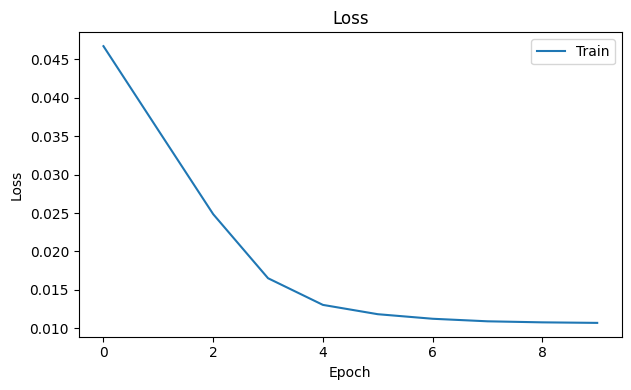

In [432]:
average_train_loss_per_sample = [loss_item / len(train_dataloader) for loss_item in train_loss]
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(len(average_train_loss_per_sample)), average_train_loss_per_sample)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train'])
plt.tight_layout()
plt.show()

In [433]:
predicted_values = []
actual_values = []
model.eval()
with torch.no_grad():
    for inputs in test_dataloader:
        inputs = [inp.to(device) for inp in inputs]
        permittivity_real, permittivity_imaginary, frequency, orientation, \
        s11_real, s11_imaginary, s12_real, s12_imaginary, \
        s21_real, s21_imaginary, s22_real, s22_imaginary = inputs
        input_features = torch.cat([frequency.unsqueeze(2),
                                    orientation.unsqueeze(2),
                                    s11_real.unsqueeze(2),
                                    s11_imaginary.unsqueeze(2),
                                    s12_real.unsqueeze(2),
                                    s12_imaginary.unsqueeze(2),
                                    s21_real.unsqueeze(2),
                                    s21_imaginary.unsqueeze(2),
                                    s22_real.unsqueeze(2),
                                    s22_imaginary.unsqueeze(2)], dim=2)
        outputs = model(input_features)
        output_real_first = outputs[0, 0]
        output_imaginary_first = outputs[0, 1]

        predicted_values.append((output_real_first.item(), output_imaginary_first.item()))
        actual_values.append((permittivity_real[0][0].item(), permittivity_imaginary[0][0].item()))
predicted_values = np.array(predicted_values)
actual_values = np.array(actual_values)

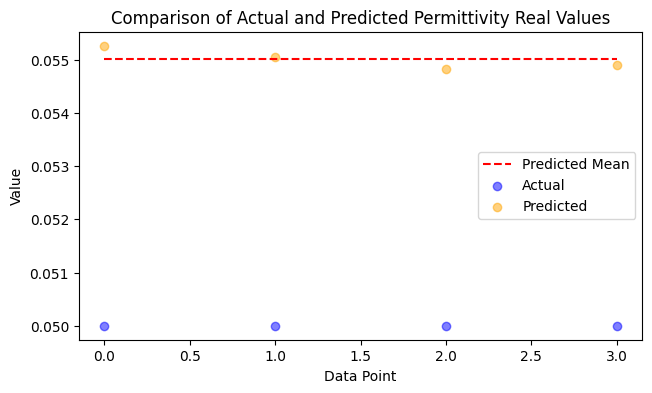

In [434]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot([0, len(actual_values) - 1], [np.mean(predicted_values[:, 0]), np.mean(predicted_values[:, 0])], label='Predicted Mean', color='red', linestyle='dashed')
plt.scatter(range(len(actual_values)), actual_values[:, 0], label='Actual', color='blue', alpha=0.5)
plt.scatter(range(len(actual_values)), predicted_values[:, 0], label='Predicted', color='orange', alpha=0.5)
plt.title('Comparison of Actual and Predicted Permittivity Real Values')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.legend()

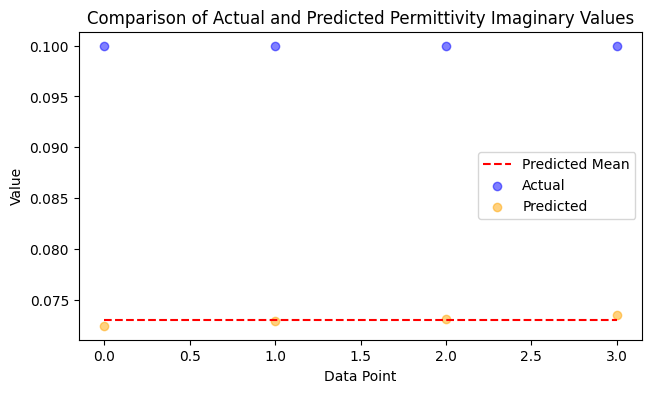

In [435]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot([0, len(actual_values) - 1], [np.mean(predicted_values[:, 1]), np.mean(predicted_values[:, 1])], label='Predicted Mean', color='red', linestyle='dashed')
plt.scatter(range(len(actual_values)), actual_values[:, 1], label='Actual', color='blue', alpha=0.5)
plt.scatter(range(len(actual_values)), predicted_values[:, 1], label='Predicted', color='orange', alpha=0.5)
plt.title('Comparison of Actual and Predicted Permittivity Imaginary Values')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.legend()